# 306_4 Anomaly Detection

<div>
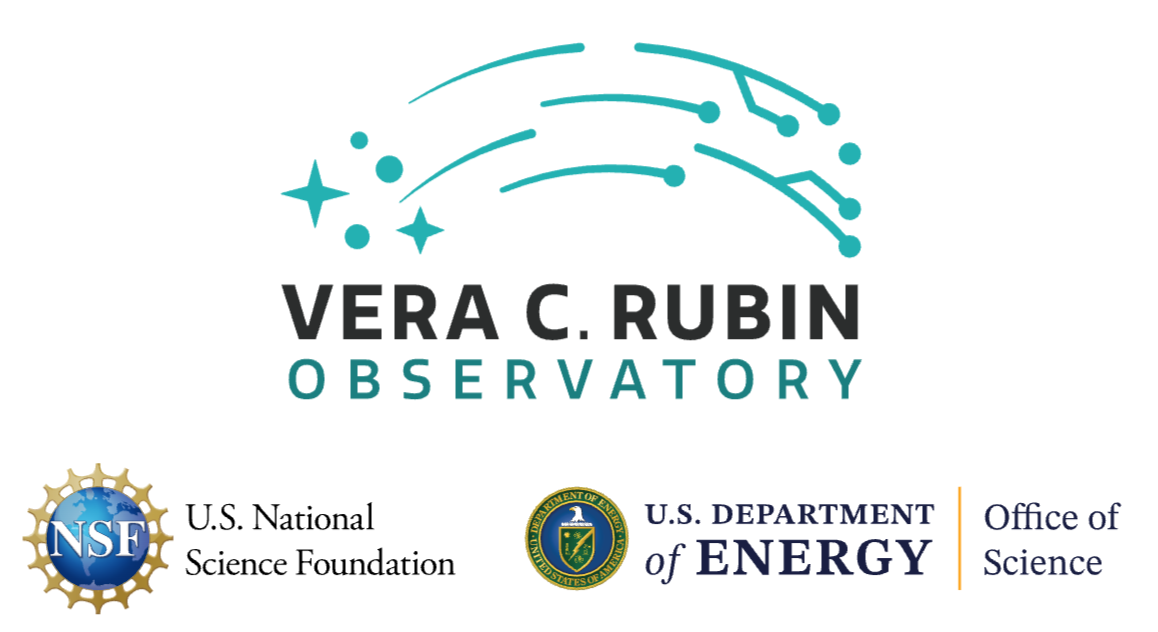
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-8-6 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** To illustrate the use of Machine Learning techniques for anomaly detection with DP1 data.

**LSST data products:** Table Access Protocol (TAP) `dp1.DiaObject`, `dp1.ForcedSourceOnDiaObject`, and `dp1.visit` tables. 

**Packages:**  `lsst`, `scikit-learn`, `pandas`, `matplotlib`, `numpy`, `astropy`.

**Credit:** Originally developed by Andrés A. Plazas Malagón, Brian Nord, and the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

Based on a [notebook prepared for the Rubin Community Workshop 2025](https://github.com/sidchaini/RubinCW25-Anomalies) by Siddharth Chaini, Andrés A. Plazas Malagón, Ryan Lau, Tatiana Acero Cuellar, with input from Federica Bianco. 

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook illustrates the use of anomaly detection techniques on objects from the Rubin Observatory's [Data Preview 1 (DP1)](https://rtn-095.lsst.io/), focusing on difference-image analysis (DIA) data products.

Anomaly detection refers to identifying rare items, events, or observations which differ significantly from the majority of the data - and may correspond to errors, rare astrophysical phenomena, or artifacts. There are many anomaly detection techniques available, including statistical methods like Principal Component Analysis (PCA), distance-based methods, clustering-based approaches, and machine learning models such as Support Vector Machines or neural networks. Several of these techniques are implemented in [`scikit-learn`](https://scikit-learn.org/stable/modules/outlier_detection.html) and other libraries.

In this notebook:

- **Section 2** applies the `IsolationForest` algorithm from [`scikit-learn`](https://scikit-learn.org/stable/), a tree-based, unsupervised anomaly detection method that works by randomly partitioning data and identifying points that are easier to isolate — typically, the outliers.

Compared to PCA, which reduces dimensionality and may detect outliers based on reconstruction error or projection distance in lower-dimensional space, Isolation Forest is more flexible and better suited to high-dimensional, non-linear feature distributions.

**References**


### 1.1. Import packages

Import general packages (`numpy`, `matplotlib`, `astropy`), the LSST packages for bulter, Table Access Protocol (TAP), display, color pallettes, and the `IsolationForest` algorithm from `scikit-learn`. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lsst.rsp import get_tap_service
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
)
from sklearn.ensemble import IsolationForest

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [2]:
service = get_tap_service("tap")
assert service is not None

Define parameters to use colorblind-friendly colors with `matplotlib`.

In [3]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Define colors, symbols, and linestyles to represent the six LSST filters, $ugrizy$.

In [4]:
filter_names = ["u", "g", "r", "i", "z", "y"]
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 2. Anomalies via isolation forest

Apply the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) from  `scikit-learn` on the DP1 `DiaObject` catalog to identify anomalous sources. 

Look for `DiaObjects` that are anomalously variable, and then inspect their light curves. 

To reduce spurious DiaObjects, set a minimum number of `DiaSource` detections.

In [7]:
ndiasources_min = 10

Focus the search for anomalous behavior from `DiaObjects` in the `r`-band.

In [8]:
band = 'r'

Set an additional threshold for number of detections in the `r`-band filter.

In [9]:
ndata_thresh = 8

Retrieve `DiaObject`s and the following statistics of their `r`-band light curve (see the `DiaObject` table in the [DP1 schema browser](https://sdm-schemas.lsst.io/dp1.html)):

**r_psfFluxMean:** Weighted mean of the diaSource PSF flux. <br>
**r_psfFluxSigma:** The standard deviation of the fluxes. <br>
**r_psfFluxLinearSlope:** Slope of a linear model fit to diaSource PSF flux vs time. <br>

Place constraints on the following quantities: 

**r_psfFluxMax:** Maximum diaSource PSF flux. <br>
**r_psfFluxMin:** Minimum diaSource PSF flux. <br>
**r_psfFluxNdata:** The number of data points used to compute `r_psfFluxChi2`. <br>
**r_scienceFluxMean:** Weighted mean of the PSF flux forced photometered at the diaSource position on the calibrated image. <br>
**nDiaSources:** Number of diaSources associated with this diaObject. <br>

Note that the statistics are all based on the _difference-image point source (PS) flux values_.

An `r`-band total mean flux (`r_scienceFluxMean`) threshold of $<5\times10^5$ nJy is set to filter out saturated sources.
Limits are also placed on the maximum `r`-band difference-image flux (`r_psfFluxMax` $<1\times10^5$ nJy) and the minimum r-band difference-image flux (`r_psfFluxMin` $>-1\times10^5$ nJy) to avoid artifacts from saturated sources.

In [10]:
diaobjid_features = [
    f"{band}_psfFluxMean",
    f"{band}_psfFluxLinearSlope",
    f"{band}_psfFluxSigma"
]

In [11]:
diaobjid_features

['r_psfFluxMean', 'r_psfFluxLinearSlope', 'r_psfFluxSigma']

Define and run the query. It may take a few seconds.

In [12]:
query = f"""
SELECT
    diaObjectId, ra, dec, 
    {', '.join(diaobjid_features)} 
FROM
    dp1.DiaObject
WHERE
    nDiaSources > {ndiasources_min}
    AND {band}_psfFluxNdata > {ndata_thresh}
    AND {band}_scienceFluxMean < 5e5
    AND {band}_psfFluxMax < 1e5
    AND {band}_psfFluxMin > -1e5 
"""

In [13]:
job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
if job.phase == "ERROR":
    job.raise_if_error()

Assert that the job finished successfully and retrieve the DIA objects as a `pandas` dataframe.

In [14]:
assert job.phase == "COMPLETED"
dia_objects = job.fetch_result().to_table().to_pandas().set_index("diaObjectId")

print(f"Retrieved {len(dia_objects)} DiaObjects.")

Retrieved 20926 DiaObjects.


Uncomment to see the table (optional).

In [15]:
# dia_objects

### 2.2. Run the isolation forest algorithm

The **Isolation Forest** algorithm detects anomalies by randomly partitioning the data using decision trees and identifying points that require fewer splits to isolate, as these are more likely to be outliers.

Run the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) on the `DiaObject` sample and look for outliers based on the `r_psfFluxMean`, `r_psfFluxLinearSlope`, and `rpsfFluxSigma`values.
The algorithm outputs anomaly scores based on the input samples where negative scores represent outliers.

Define the sample.

In [16]:
sample = dia_objects[[
    f'{band}_psfFluxMean',
    f'{band}_psfFluxLinearSlope',
    f'{band}_psfFluxSigma',
]].values

Make an instance of an `IsolationForest` object, with a deterministic state, and call the fit estimator. 
Relevant parameters for configuring `IsolationForest` include `max_samples` (number of training points per tree), `contamination` (expected outlier fraction), and `random_state` (for reproducibility).
For a full list of parameters and their descriptions, see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

In [17]:
rng = np.random.RandomState(42)
ifo = IsolationForest(max_samples=1000,
                      random_state=rng, n_jobs=1)
ifo.fit(sample)

,n_estimators,100
,max_samples,1000
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,1
,random_state,RandomState(M...0x77FC03E91B40
,verbose,0
,warm_start,False


Get the Isolation Forest scores from the input sample, and show them in a histogram. 

In [18]:
scores = ifo.score_samples(sample)

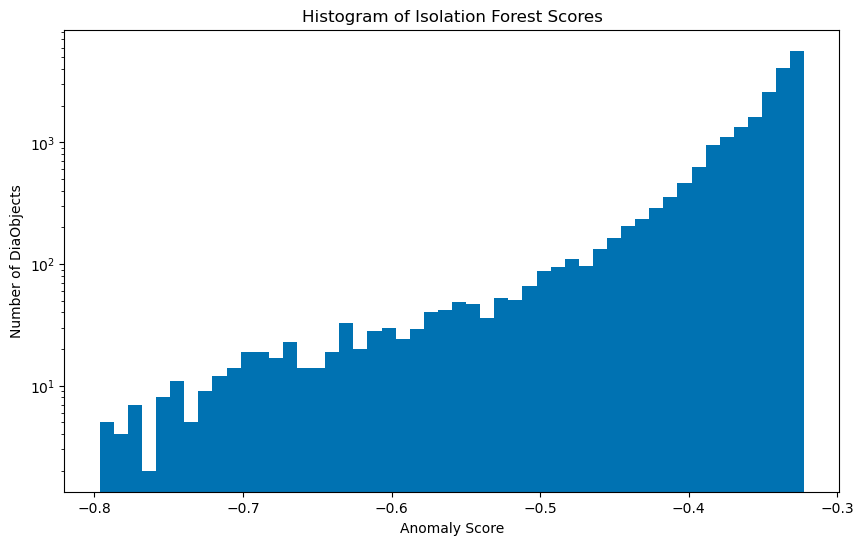

In [19]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Isolation Forest Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

> Figure 1: Histogram of Isolation Forest scores from the input sample. Scores with the most negative values indicate outliers.

The anomaly scores defined in the original Isolation Forest paper by [Liu et al. (2008)](https://ieeexplore.ieee.org/document/4781136) range between 0 and 1, and can be interpreted as follows:

- (a) If instances return a score very close to 1, they are likely to be anomalies.  
- (b) If instances have a score much smaller than 0.5, they are likely to be normal.  
- (c) If all instances return scores around 0.5, then the sample likely does not contain any distinct anomalies.

The [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.score_samples) explains that the measure of normality for an observation is based on the depth of the leaf node that contains the observation in the isolation trees — this depth corresponds to the number of splits required to isolate the point.

Importantly, the `score_samples` function in scikit-learn returns **the negative of the original Liu et al. (2008) scores**, such that **more negative values indicate more abnormal observations**.

### 2.3. Visualize the Identified Anomalies

Plot the distribution of DiaObjects with the properties used to identify outliers: `{band}_psfFluxMean`, `{band}_psfFluxLinearSlope`, and `{band}_psfFluxSigma`.

Get the top 20 outliers, based on their scores.

In [20]:
idx = np.argsort(ifo.score_samples(sample))[:20]

In [21]:
outlier_diaobject_ids = dia_objects.index[idx]

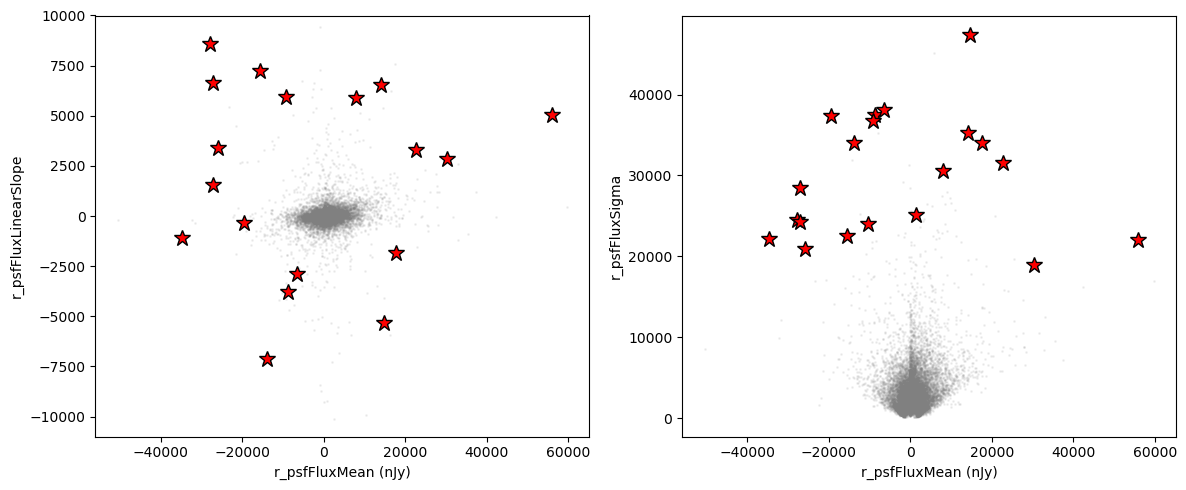

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=False)

params = [
    (f'{band}_psfFluxMean', f'{band}_psfFluxLinearSlope'),
    (f'{band}_psfFluxMean', f'{band}_psfFluxSigma'),
]

for j, (px, py) in enumerate(params):
    ax[j].plot(dia_objects[px], dia_objects[py], 'o', ms=1, color='grey', alpha=0.1)
    ax[j].set_xlabel(px + " (nJy)")
    ax[j].set_ylabel(py)
    for i in outlier_diaobject_ids:
        ax[j].plot(dia_objects[px][i], dia_objects[py][i], '*', ms=12, color='red', mec='black')

ax[0].set_ylim([-11000, 10000])
plt.tight_layout()
plt.show()

> Figure 2: Distribution of `DiaObject`s showing (Left) ``r_psfFluxLinearSlope`` vs ``r_psfFluxMean`` and (Right) ``r_psfFluxSigma`` vs ``r_psfFluxMean``. The top 20 anomalies identified from the `IsolationForest` algorithm (red star) indeed appear to be outliers in the distribution of other `DiaObject`s (grey points).

Query and plot the light curves of the top 20 `DiaObject` outliers, in all bands with available data.

First, retrieve the **forced photometry light curves** for a selected set of outlier `diaObjectId`s from the `ForcedSourceOnDiaObject` table in the DP1 dataset. 
    
The query includes:

- The photometric **band**s.
- The **PSF-fit difference flux** and its **error**
- The **exposure midpoint time** (`expMidptMJD`)

Perform a joint query with the `Visit` table to obtain the observation time for each measurement.

In [21]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({', '.join(map(str, outlier_diaobject_ids))})
"""

In [22]:
job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

Plot the light curves.

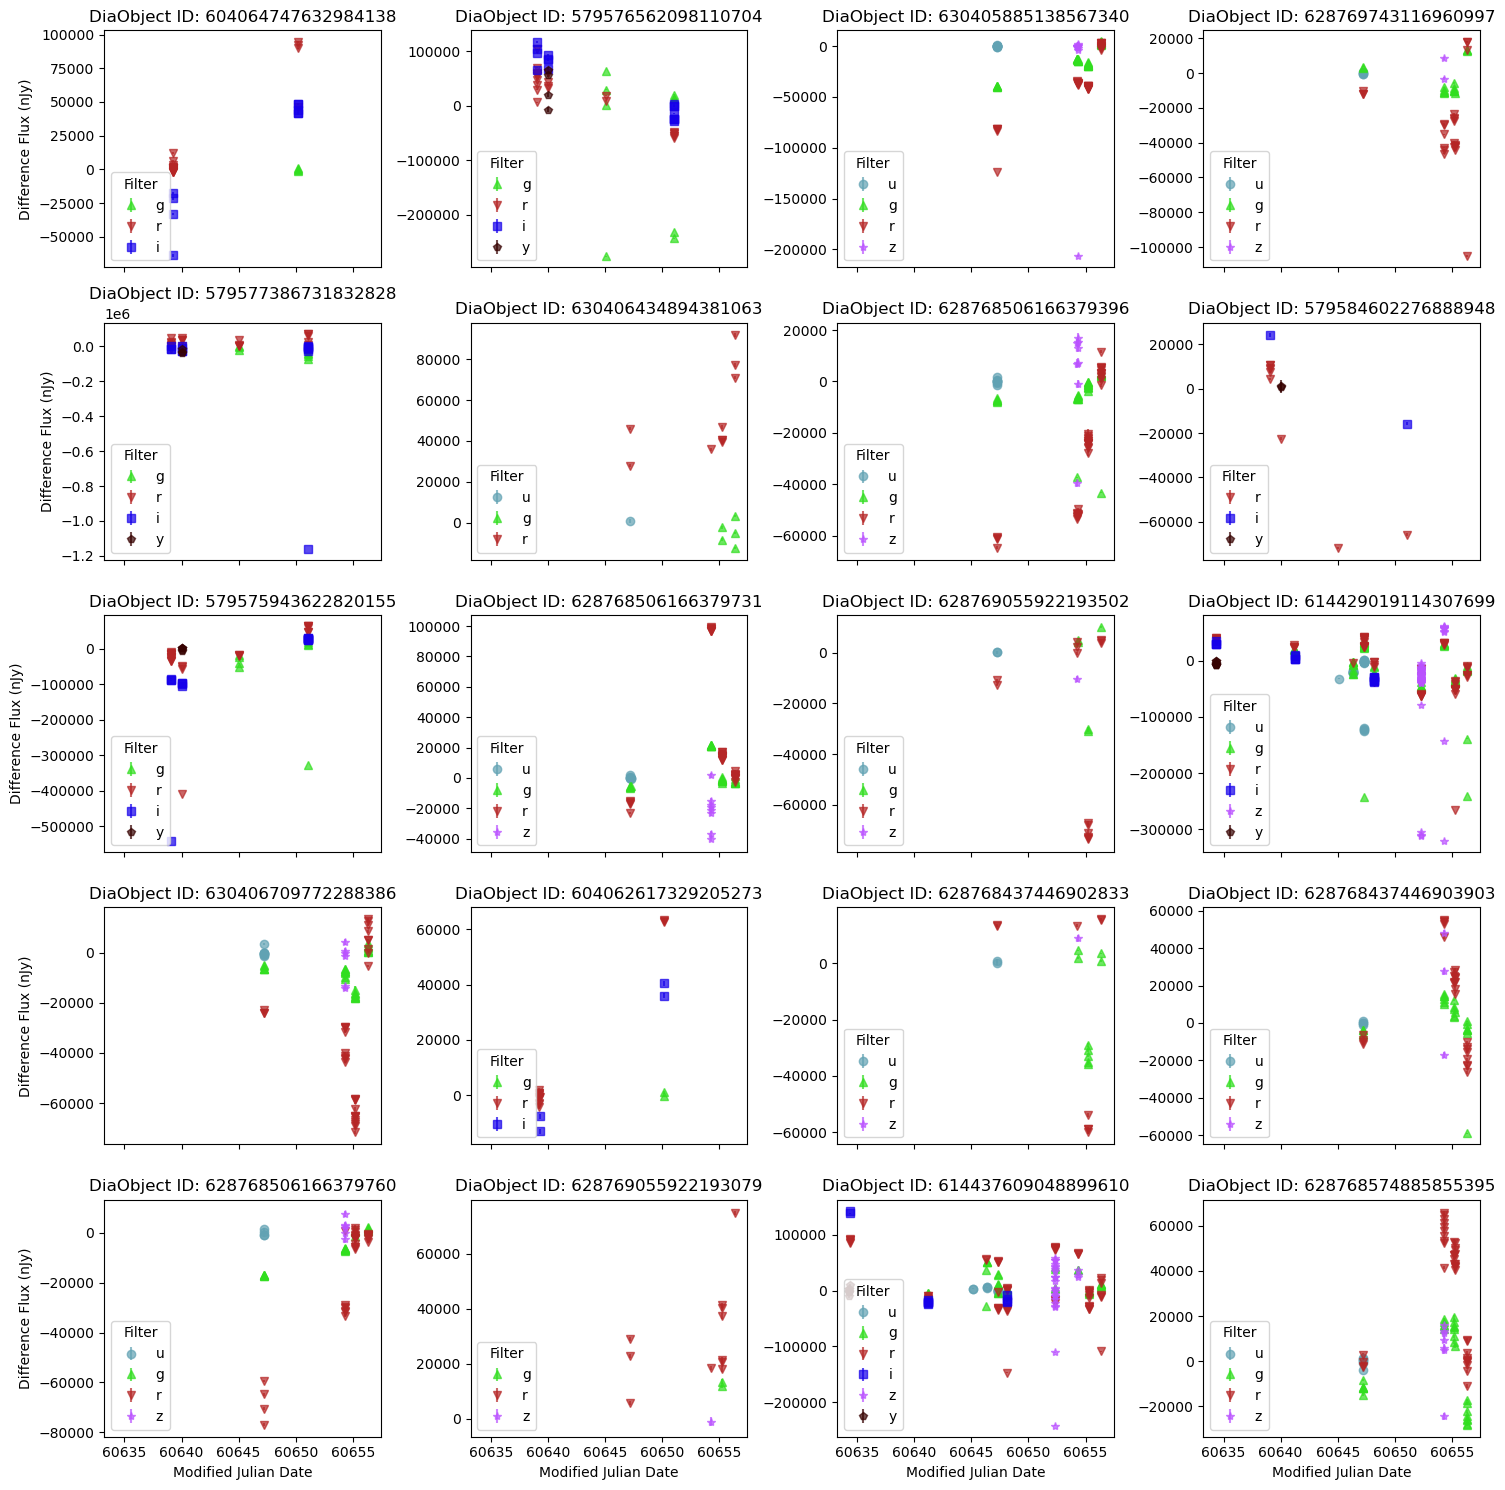

In [23]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for this_band in filter_names:
        band_data = object_data[object_data["band"] == this_band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[this_band],
                color=filter_colors[this_band],
                label=this_band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

    if i not in [12]:
        ax.legend(title="Filter", loc='lower left')

plt.tight_layout()
plt.show()

> Figure 3: Multi-band light curves of the top 20 `DiaObject` outliers.

## 4. Exercises for the learner

- Use a different algorithm for classification, e.g., `DistClassiPy` (see the package [documentation](https://sidchaini.github.io/DistClassiPy/)), a Python package for distance-based classification that supports multiple distance metrics, to explore alternative anomaly detection strategies on the same dataset. See the notebook examples in https://github.com/sidchaini/RubinCW25-Anomalies.

- Use a feature extractor on every light curve and then perform anomaly detection as discussed in this tutorial. Example sof feature-extraction algorithms include [ALeRCE](https://github.com/alercebroker/pipeline)([Sánchez-Sáez+21](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)) or [```light-curve```]((https://github.com/light-curve/light-curve-python))[(Malanchev+21)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract).